In [2]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F  
import matplotlib 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.utils.data
from torch.utils.data import DataLoader

In [3]:
EPSILON = 0.1       # Max perturbation (for L∞ PGD)
ALPHA = 0.01         # Step size per iteration
ATTACK_ITERATIONS = 40
TARGET_LABEL = 1     # Example target label for the targeted attack

# System/Model parameters
sys.path.append("/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/best_model_retrained.pth"
IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/Pluto_10_windows_runs2_3/Pluto_10_2m_run3.iq"

#IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_0_1m_run3.iq"



In [4]:

from attempt2 import resnet50_1d  # Directly import from attempt2.py
num_classes = 8  # Change this if your model was trained with a different number of classes

# Initialize the model architecture
model = resnet50_1d(num_classes=num_classes).to(DEVICE)

# Load trained weights
print(f"Loading trained model weights from: {MODEL_PATH}")
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()


Loading trained model weights from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/best_model_retrained.pth


/tmp/ipykernel_3210391/2189494409.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


ResNet1D(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck1D(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True

In [5]:
class IQDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        sample = torch.from_numpy(sample).float()
        # Normalize data
        magnitude = torch.sqrt(torch.sum(sample**2, dim=1, keepdim=True))
        sample = sample / magnitude

        label_tensors = torch.tensor(label, dtype=torch.long)

        return sample, label_tensors

In [6]:
TRUE_IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_1_2m_run3.iq"
BATCH_SIZE = 16
WINDOW_SIZE = 10000
HOP_SIZE = 500
START_INDEX = 4800
END_INDEX = 6000

# Initialize and load model
model = resnet50_1d(num_classes=8)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


fname = os.path.basename(TRUE_IQ_FILE_PATH)
print(f"\nProcessing file: {TRUE_IQ_FILE_PATH}")

# Extract label from filename: Pluto_#_...
try:
    target_label = int(fname.split("_")[1])
except (IndexError, ValueError):
    print(f"  Warning: could not parse label from filename: {fname}")
    

# Load IQ data
data = np.fromfile(TRUE_IQ_FILE_PATH, dtype="float32")
real_part = data[0::2]
imag_part = data[1::2]

test_data_tensors = []
test_label_tensors = []

# Sliding window generation
for x in range(START_INDEX, END_INDEX):
    start = (x + 1) * HOP_SIZE
    end = start + WINDOW_SIZE
    if end > len(real_part): break

    i_window = real_part[start:end]
    q_window = imag_part[start:end]
    combined = np.vstack((i_window, q_window))  # [2, WINDOW_SIZE]
    test_data_tensors.append(combined)
    test_label_tensors.append(target_label)

if not test_data_tensors:
    print(f"Skipping {fname}: not enough valid IQ segments.")
    

# Stack and shuffle
test_data_tensors = np.stack(test_data_tensors, axis=0)
test_label_tensors = np.array(test_label_tensors)
indices = np.random.permutation(len(test_data_tensors))
test_data = test_data_tensors[indices]
test_labels = test_label_tensors[indices]

# Create Dataset + Loader
test_dataset = IQDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate
correct = 0
total = 0
mismatch_count = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        mismatch_count += (predicted != labels).sum().item()
        correct += (predicted == labels).sum().item()

acc = correct / total * 100
print(f"[{fname}] Accuracy: {acc:.2f}% | Mismatches: {mismatch_count} / {total}")


/tmp/ipykernel_3210391/3472265293.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))



Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_1_2m_run3.iq
[Pluto_1_2m_run3.iq] Accuracy: 95.75% | Mismatches: 51 / 1200


In [7]:
def targeted_pgd_attack(model, x, y, target_label, eps, alpha, num_iter):

    model.eval()
    
    if isinstance(target_label, int):
        target_label = torch.full_like(y, target_label)
    
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True

    for _ in range(num_iter):
        outputs = model(x_adv)
        
        loss = -nn.CrossEntropyLoss()(outputs, target_label)

        model.zero_grad()
        loss.backward()

        grad = x_adv.grad.data
        x_adv = x_adv.detach() + alpha * grad.sign()

        x_adv = torch.min(torch.max(x_adv, x - eps), x + eps)

        x_adv.requires_grad = True

    return x_adv.detach()

Loading data from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/Pluto_10_windows_runs2_3/Pluto_10_2m_run3.iq
True label: 10, Target label: 1
Original prediction: 1, Confidence: 0.6511
Adversarial prediction: 1, Confidence: 1.0000
Saved perturbation to Apr27/pluto10_to_target1_noise.iq


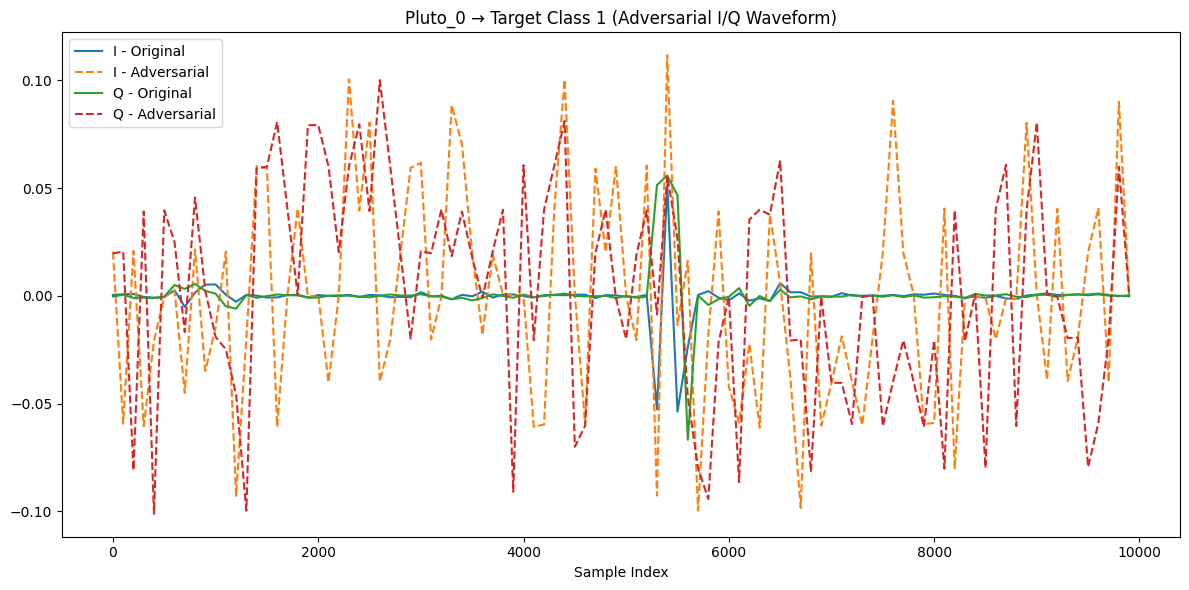

In [41]:
def main():
    print(f"Loading data from: {IQ_FILE_PATH}")

    # Use true label from filename (Pluto_0 → class 0)
    label = int(os.path.basename(IQ_FILE_PATH).split("_")[1])  # This will be 0
    print(f"True label: {label}, Target label: {TARGET_LABEL}")

    # Load and format IQ data
    data = np.fromfile(IQ_FILE_PATH, dtype="float32")
    real = data[0::2]
    imag = data[1::2]

    start = (START_INDEX + 1) * HOP_SIZE
    end = start + WINDOW_SIZE
    i_window = real[start:end]
    q_window = imag[start:end]
    combined = np.vstack((i_window, q_window))  # [2, N]

    # Wrap in Dataset for normalization
    test_dataset = IQDataset([combined], [label])
    data_tensor, label_tensor = test_dataset[0]
    data_tensor = data_tensor.unsqueeze(0).to(DEVICE)
    label_tensor = label_tensor.unsqueeze(0).to(DEVICE)

    # Prediction before attack
    with torch.no_grad():
        logits = model(data_tensor)
        probs = F.softmax(logits, dim=1)
        orig_pred = torch.argmax(probs, dim=1)
        orig_conf = probs.max(dim=1).values

    print(f"Original prediction: {orig_pred.item()}, Confidence: {orig_conf.item():.4f}")

    # PGD attack targeting label 1
    x_adv = targeted_pgd_attack(
        model=model,
        x=data_tensor,
        y=label_tensor,
        target_label=TARGET_LABEL,
        eps=EPSILON,
        alpha=ALPHA,
        num_iter=ATTACK_ITERATIONS
    )

    with torch.no_grad():
        logits_adv = model(x_adv)
        probs_adv = F.softmax(logits_adv, dim=1)
        adv_pred = torch.argmax(probs_adv, dim=1)
        adv_conf = probs_adv.max(dim=1).values

    print(f"Adversarial prediction: {adv_pred.item()}, Confidence: {adv_conf.item():.4f}")

    # Save perturbation
    original_np = data_tensor.squeeze().cpu().numpy()
    adv_np = x_adv.squeeze().cpu().numpy()
    I_diff = adv_np[0] - original_np[0]
    Q_diff = adv_np[1] - original_np[1]

    interleaved = np.empty(I_diff.size + Q_diff.size, dtype=np.float32)
    interleaved[0::2] = I_diff
    interleaved[1::2] = Q_diff

    save_path = "Apr27/pluto10_to_target1_noise.iq"
    interleaved.tofile(save_path)
    print(f"Saved perturbation to {save_path}")

    # Plot
    time = np.arange(original_np.shape[1])
    ds = 100
    plt.figure(figsize=(12, 6))
    plt.plot(time[::ds], original_np[0][::ds], label="I - Original")
    plt.plot(time[::ds], adv_np[0][::ds], '--', label="I - Adversarial")
    plt.plot(time[::ds], original_np[1][::ds], label="Q - Original")
    plt.plot(time[::ds], adv_np[1][::ds], '--', label="Q - Adversarial")
    plt.legend()
    plt.title("Pluto_0 → Target Class 1 (Adversarial I/Q Waveform)")
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    main()


Test the newly generated sample

In [8]:
import numpy as np
from scipy.signal import kaiserord, firwin, lfilter
import gzip
import pickle
import scipy.signal as signal
import math
import torch

### Transmitter Data ###
# Parameters
FILENAME_TX = f"/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/Pluto_10_windows_runs2_3/Pluto_10_2m_run3.iq"
print("Current Transmitter File Processing: ", FILENAME_TX)
# Read in the data
data_tx = np.fromfile(FILENAME_TX, dtype="float32")
# Bring I and Q into one value
I = data_tx[0::2]
Q = data_tx[1::2]
data_complex_tx = I + 1j*Q

### Adversary Noise Data ###
FILENAME_ADV_TX = f"Apr27/pluto10_to_target1_noise.iq"
print("Current Adversary Noise File Processing: ", FILENAME_ADV_TX)
# Read in the data
data_adv_tx = np.fromfile(FILENAME_ADV_TX, dtype="float32")
# Bring I and Q into one value
I = data_adv_tx[0::2]
Q = data_adv_tx[1::2]
data_complex_adv_tx = I + 1j*Q

def path_loss(signal, n, d1, d2):
    scaling = (d1 / d2) ** (n / 2)
    return signal * scaling

def apply_rician_fading(signal, k=20.0):
    h_nlos = (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape)) / np.sqrt(2)
    h_los = np.ones_like(signal, dtype=signal.dtype)
    scaling_los = np.sqrt(k / (k + 1))
    scaling_nlos = np.sqrt(1 / (k + 1))
    h_rician = scaling_los * h_los + scaling_nlos * h_nlos
    return signal * h_rician

def apply_awgn(signal, noise_std=0.000001):
    noise = noise_std * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape)) / np.sqrt(2)
    return signal + noise

def generate_combined():
    # Adjust
    # Path loss exponent
    n = 2
    # Reference distance
    d1 = 1 
    # Actual distance
    d2 = 2
    # Noise
    noise_std = 0.000001
    #data_complex_adv_tx = torch.from_numpy(data_complex_adv_tx).to(torch.cfloat)
    # Path loss
    iq_path = path_loss(data_complex_adv_tx, n, d1,d2)
    
    
    iq_scaled = apply_rician_fading(iq_path)
    
    iq_received = apply_awgn(iq_scaled)
    
    iq_received = data_complex_adv_tx
    
    ### Combine Datas ###
    len_data_complex_tx = len(data_complex_tx)
    print("Length of transmitter: ", len_data_complex_tx)
    len_data_complex_adv_tx = len(data_complex_adv_tx)
    print("Length of noise: ", len_data_complex_adv_tx)
    num_chunks = len_data_complex_tx // len_data_complex_adv_tx
    combined_array = data_complex_tx.copy()
    for i in range(num_chunks):
        start = i * len_data_complex_adv_tx
        end = start + len_data_complex_adv_tx
        combined_array[start:end] = data_complex_tx[start:end] + iq_received
    
    print("Original Tx: ", data_complex_tx)
    print("Noise: ", data_complex_adv_tx)
    print("Path loss noise: ", iq_path)
    print("Rician noise: ", iq_scaled)
    print("With noise: ", iq_received)
    print("Combined: ", combined_array)
    
    real = combined_array.real
    imag = combined_array.imag
    data_to_save = [elem for pair in zip(real, imag) for elem in pair]
    data_to_save = np.array(data_to_save)
    filtered_signal_float32 = data_to_save.astype("float32")
    filtered_signal_float32.tofile("Apr27/test_sample_noise.iq")

#generate_combined()


Current Transmitter File Processing:  /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/Pluto_10_windows_runs2_3/Pluto_10_2m_run3.iq
Current Adversary Noise File Processing:  Apr27/pluto10_to_target1_noise.iq


In [48]:
import numpy as np

def apply_eot(
    adv_signal,
    n=2.0,
    reference_distance=2.0,
    distances=[1.0, 4.0],
    k=20.0,
    noise_std=0.000001
):

    # 1. Randomly choose a distance
    d_choice = 2 #np.random.choice(distances)
    
    # 2. Apply path loss
    scaling = (reference_distance / d_choice) ** (n / 2)
    signal_scaled = adv_signal * scaling
    
    # 3. Apply Rician fading
    h_nlos = (np.random.randn(*signal_scaled.shape) + 1j * np.random.randn(*signal_scaled.shape)) / np.sqrt(2)
    h_los = np.ones_like(signal_scaled, dtype=signal_scaled.dtype)
    scaling_los = np.sqrt(k / (k + 1))
    scaling_nlos = np.sqrt(1 / (k + 1))
    h_rician = scaling_los * h_los + scaling_nlos * h_nlos
    signal_faded = signal_scaled * h_rician

    # 4. Add AWGN noise
    noise = noise_std * (np.random.randn(*signal_faded.shape) + 1j * np.random.randn(*signal_faded.shape)) / np.sqrt(2)
    signal_eot = signal_faded + noise
    
    return signal_eot




In [49]:
def generate_eot():
    # Adjust
    # Path loss exponent
    n = 2
    # Reference distance
    d1 = 1 
    # Actual distance
    d2 = 2
    # Noise
    noise_std = 0.000001
    #data_complex_adv_tx = torch.from_numpy(data_complex_adv_tx).to(torch.cfloat)
    # Path loss
    
    ### Combine Datas ###
    len_data_complex_tx = len(data_complex_tx)
    print("Length of transmitter: ", len_data_complex_tx)
    len_data_complex_adv_tx = len(data_complex_adv_tx)
    print("Length of noise: ", len_data_complex_adv_tx)
    num_chunks = len_data_complex_tx // len_data_complex_adv_tx
    combined_array = data_complex_tx.copy()

    for i in range(num_chunks):
        start = i * len_data_complex_adv_tx
        end = start + len_data_complex_adv_tx
        
        # Apply full EOT to the adversary signal
        adv_transformed = apply_eot(
            data_complex_adv_tx,
            n=2.0,
            reference_distance=1.0,
            distances=[1.0, 2.0],  # <-- your x and x'
            k=20.0,
            noise_std=0.000001
        )
        
        #combined_array[start:end] = data_complex_tx[start:end] + adv_transformed
        combined_array[start:end] = adv_transformed
        
    real = combined_array.real
    imag = combined_array.imag
    data_to_save = [elem for pair in zip(real, imag) for elem in pair]
    data_to_save = np.array(data_to_save)
    filtered_signal_float32 = data_to_save.astype("float32")
    filtered_signal_float32.tofile("Apr27/test3.iq")
    
generate_eot()

Length of transmitter:  41469120
Length of noise:  10000


In [ ]:
#path loss fading on pluto10 


def generate_eot():
    # Adjust
    # Path loss exponent
    n = 2
    # Reference distance
    d1 = 1 
    # Actual distance
    d2 = 2
    # Noise
    noise_std = 0.000001
    #data_complex_adv_tx = torch.from_numpy(data_complex_adv_tx).to(torch.cfloat)
    # Path loss
    
    ### Combine Datas ###
    len_data_complex_tx = len(data_complex_tx) #pluto len
    print("Length of transmitter: ", len_data_complex_tx)
    len_data_complex_adv_tx = len(data_complex_adv_tx)
    print("Length of noise: ", len_data_complex_adv_tx)
    num_chunks = len_data_complex_tx // len_data_complex_adv_tx
    combined_array = data_complex_tx.copy()

    for i in range(num_chunks):
        start = i * len_data_complex_adv_tx
        end = start + len_data_complex_adv_tx
        
        # Apply full EOT to the adversary signal
        adv_transformed = apply_eot(
            data_complex_tx[:10000],
            #data_complex_adv_tx
            n=2.0,
            reference_distance=1.0,
            distances=[1.0, 2.0],  # <-- your x and x'
            k=20.0,
            noise_std=0.000001
        )
        
        combined_array[start:end] = data_complex_adv_tx
        
    real = combined_array.real
    imag = combined_array.imag
    data_to_save = [elem for pair in zip(real, imag) for elem in pair]
    data_to_save = np.array(data_to_save)
    filtered_signal_float32 = data_to_save.astype("float32")
    filtered_signal_float32.tofile("Apr27/eot_on_pluto.iq")
    
generate_eot()

In [ ]:
def differentiable_eot(delta, n=2.0, reference_distance=1.0, distance=2.0, k=20.0, noise_std=0.00001):
    # Path loss
    scale = (reference_distance / distance) ** (n / 2)
    delta_scaled = delta * scale
    
    # Rician fading
    h_nlos = (torch.randn_like(delta) + 1j * torch.randn_like(delta)) / math.sqrt(2)
    h_los = torch.ones_like(delta)
    h_rician = math.sqrt(k / (k + 1)) * h_los + math.sqrt(1 / (k + 1)) * h_nlos
    delta_faded = delta_scaled * h_rician

    # AWGN
    noise = noise_std * (torch.randn_like(delta) + 1j * torch.randn_like(delta)) / math.sqrt(2)
    return delta_faded + noise


def pgd_with_eot(model, loss_fn, x_clean, target_label, num_steps=40, alpha=0.01, epsilon=0.1):
    device = next(model.parameters()).device  # Get model's device (CPU or GPU)

    x_clean = x_clean.to(device)
    target_label = target_label.to(device)

    delta = torch.zeros_like(x_clean, dtype=torch.cfloat, requires_grad=True, device=device)

    for _ in range(num_steps):
        model.zero_grad()

        # Apply channel effects to perturbation
        delta_transformed = differentiable_eot(delta, distance=torch.FloatTensor(1).uniform_(1.0, 2.0).item()).to(device)

        # Combine clean signal and perturbation
        x_adv = x_clean + delta_transformed  # shape: [chunk_size]

        # Convert to 2-channel real: [2, chunk_size]
        x_adv_iq = torch.stack([x_adv.real, x_adv.imag], dim=0).unsqueeze(0)  # [1, 2, chunk_size]

        # Forward + backward
        logits = model(x_adv_iq)
        loss = loss_fn(logits, target_label.unsqueeze(0))
        loss.backward()

        # PGD step
        grad = delta.grad.detach()
        delta = delta + alpha * grad / (torch.norm(grad) + 1e-10)
        delta_real = torch.clamp(delta.real, -epsilon, epsilon)
        delta_imag = torch.clamp(delta.imag, -epsilon, epsilon)
        delta = torch.complex(delta_real, delta_imag)

        delta = delta.detach().requires_grad_(True).to(device)

    return delta

def generate_dynamic_eot(target_label):
    # Parameters
    n = 2
    d1 = 1.0
    distances = [1.0, 2.0]
    k = 20.0
    noise_std = 0.000001
    loss_fn = torch.nn.CrossEntropyLoss()

    # Convert to torch tensors
    device = next(model.parameters()).device
    tx_tensor = torch.from_numpy(data_complex_tx).to(torch.cfloat).to(device)
    len_data_complex_tx = len(tx_tensor)

    # Define chunk size: same as original adversarial perturbation length
    len_data_complex_adv_tx = len(data_complex_adv_tx)
    chunk_size = len_data_complex_adv_tx
    num_chunks = len_data_complex_tx // chunk_size

    combined_array = tx_tensor.clone()

    for i in range(num_chunks):
        start = i * chunk_size
        end = start + chunk_size

        x_clean = tx_tensor[start:end]

        # Expand scalar target label to match model batch
        label_tensor = torch.tensor(target_label, dtype=torch.long)


        # Run PGD with EOT to generate robust perturbation
        delta = pgd_with_eot(
            model=model,
            loss_fn=loss_fn,
            x_clean=x_clean,
            target_label=label_tensor,
            num_steps=40,
            alpha=0.01,
            epsilon=0.1
        )

        # Apply optimized perturbation
        combined_array[start:end] = x_clean + delta.detach()

    # Save the result
    combined_np = combined_array.cpu().numpy()
    real = combined_np.real
    imag = combined_np.imag
    data_to_save = np.empty(2 * len(real), dtype="float32")
    data_to_save[0::2] = real
    data_to_save[1::2] = imag
    data_to_save.tofile("Apr27/dynamic_eot_pgd_optimized.iq")



generate_dynamic_eot(1)

In [45]:


class IQDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        sample = torch.from_numpy(sample).float()
        # Normalize data
        magnitude = torch.sqrt(torch.sum(sample**2, dim=1, keepdim=True))
        sample = sample / magnitude

        label_tensors = torch.tensor(label, dtype=torch.long)

        return sample, label_tensors


file_name = "Apr27/eot_sample_8m_noise.iq"
test_data_tensors = []
test_label_tensors = []
target = 1
data = np.fromfile(file_name, dtype="float32")
size_data = len(data)
print("Size of data: ", size_data)
size_half = int(size_data / 2)
real_part = data[0::2]
print("Real Length: ", len(real_part))
imag_part = data[1::2]
print("Imag Length: ", len(imag_part))


for x in range(4800, 6000):
    # Implement a 10% hop
    combined_data = np.vstack((real_part[(x+1)*500:(x+1)*500+10000], imag_part[(x+1)*500:(x+1)*500+10000]))
    array = np.zeros(combined_data.shape[1])
    array.fill(target)
    test_data_tensors.append(combined_data)
    test_label_tensors.append(target)


# Format the data
test_data_tensors = np.stack(test_data_tensors, axis=0)
test_label_tensors = np.array(test_label_tensors)

# Randomize the data
indices = np.random.permutation(len(test_data_tensors))
test_data = test_data_tensors[indices]
test_labels = test_label_tensors[indices]
print(test_data.shape)
print(test_labels.shape)

# Create the dataset
test_dataset = IQDataset(test_data, test_labels)

batch_size = 16

# Load the data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.manual_seed(7)
np.random.seed(7)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = resnet50_1d(num_classes=8)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
#summary(net, input_size = (1, 2), batch_size = 8)


dataiter = iter(test_loader)
images, labels = next(dataiter)

correct = 0
total = 0
conf_threshold = 0.85
fooled = 0
confidence = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)    # <--- ADD THIS
        labels = labels.to(DEVICE)    # <--- (optional, only if you also need labels on GPU)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        #for x in range(0, len(predicted)):
        #    print(predicted)
        #    print(labels)
        #    if ~(predicted[x] == labels[x]):
        #        print("Predicted: ", predicted[x])
        #        print("Label: ", labels[x])
        correct += (predicted == labels).sum().item()
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, classes = torch.max(probs, 1)
        
        # For GAN
        
        counter = 0
        for conf_i in conf:
            # For testing normal mode
            if conf_i > conf_threshold and labels[counter] == target:
            # For generative attack
            #if (conf_i > conf_threshold):
                fooled = fooled + 1
                confidence = confidence + conf_i
            counter = counter + 1
        


### For Attack ###
fooled_acc = fooled / total * 100
if (fooled == 0):
    print("No fools")
else:
    fooled_conf = confidence / fooled * 100
    print("Average confidence: ", fooled_conf)
print('Percentage of successful fools: %d %%' % (fooled_acc))
print("Number fooled: ", fooled)
print("Number total: ", total)


Size of data:  82938240
Real Length:  41469120
Imag Length:  41469120
(1200, 2, 10000)
(1200,)


/tmp/ipykernel_3210391/3327162996.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


Average confidence:  tensor(99.3133, device='cuda:0')
Percentage of successful fools: 95 %
Number fooled:  1149
Number total:  1200


EOT
Percentage of successful fools: 95 %
Number fooled:  1140
Number total:  1200

Regualr PGD noise
Percentage of successful fools: 86 %
Number fooled:  1034
Number total:  1200

In [54]:
def targeted_eot_pgd_attack(
    model,
    x,
    y,
    target_label,
    eps=0.1,
    alpha=0.01,
    num_iter=80,
    num_samples=10,
    min_distance=1.0,
    max_distance=2.0,
    path_loss_exponent=2.0,
    reference_distance=1.0,
    noise_std=0.01,
    apply_fading=True,
    apply_phase=True
):
    x_adv = x.clone().detach().requires_grad_(True).to(DEVICE)
    target = torch.full_like(y, target_label)

    for i in range(num_iter):
        total_grad = torch.zeros_like(x_adv)

        for _ in range(num_samples):
            x_t = transform_channel_effects(             #either add inverse or normal fading
                x_adv,
                min_distance=min_distance,
                max_distance=max_distance,
                path_loss_exponent=path_loss_exponent,
                reference_distance=reference_distance,
                noise_std=noise_std,
                apply_fading=apply_fading,
                apply_phase=apply_phase
            )

            logits = model(x_t)
            loss = F.cross_entropy(logits, target)

            grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]
            total_grad += grad

        avg_grad = total_grad / num_samples

        with torch.no_grad():
            x_adv -= alpha * avg_grad.sign()
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
            x_adv = x_adv.detach().clone().requires_grad_(True)

    return x_adv

def generate_eot_pgd_noise():
    print(f"Loading data from: {IQ_FILE_PATH}")
    label = int(os.path.basename(IQ_FILE_PATH).split("_")[1])
    print(f"True label: {label}, Target label: {TARGET_LABEL}")

    # Load IQ data
    data = np.fromfile(IQ_FILE_PATH, dtype="float32")
    real = data[0::2]
    imag = data[1::2]
    start = (START_INDEX + 1) * HOP_SIZE
    end = start + WINDOW_SIZE
    i_window = real[start:end]
    q_window = imag[start:end]
    combined = np.vstack((i_window, q_window))  # [2, N]

    # Format into dataset
    test_dataset = IQDataset([combined], [label])
    data_tensor, label_tensor = test_dataset[0]
    data_tensor = data_tensor.unsqueeze(0).to(DEVICE)
    label_tensor = label_tensor.unsqueeze(0).to(DEVICE)
    min_distance=1.0
    max_distance=2.0
    EPSILON = 0.1
    ALPHA = 0.02
    ATTACK_ITERATIONS = 40
    if min_distance >= 5.0:
        EPSILON = 0.6
        ALPHA = 0.021
        ATTACK_ITERATIONS = 100

    # EoT PGD attack
    #x_adv = data_tensor.clone().detach().to(DEVICE)

    x_adv = targeted_eot_pgd_attack(
        model=model,
        x=data_tensor,
        y=label_tensor,
        target_label=TARGET_LABEL,
        eps=EPSILON,
        alpha=ALPHA,
        num_iter=ATTACK_ITERATIONS,
        num_samples=10,
        min_distance=min_distance,
        max_distance=max_distance,
        noise_std=0.001 
    )

    # Save perturbation only
    original_np = data_tensor.squeeze().cpu().numpy()
    adv_np = x_adv.squeeze().detach().cpu().numpy()

    I_diff = adv_np[0] - original_np[0]
    Q_diff = adv_np[1] - original_np[1]

    interleaved = np.empty(I_diff.size + Q_diff.size, dtype=np.float32)
    interleaved[0::2] = I_diff
    interleaved[1::2] = Q_diff

    save_path = "Apr25/mid_dist_eot_pluto10_to_target1_noise.iq"
    interleaved.tofile(save_path)
    print(f"Saved EoT PGD noise to {save_path}")

    # --- Evaluate by re-applying noise to original signal ---
    print(f"\nTesting saved EoT noise from: {save_path}")
    noise = np.fromfile(save_path, dtype=np.float32)
    I_noise = noise[0::2]
    Q_noise = noise[1::2]

    perturbed = np.vstack((i_window + I_noise, q_window + Q_noise))
    test_dataset = IQDataset([perturbed], [label])
    data_tensor_adv, _ = test_dataset[0]
    data_tensor_adv = data_tensor_adv.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits_adv = model(data_tensor_adv)
        probs_adv = F.softmax(logits_adv, dim=1)
        print(f"Full softmax probabilities:\n{probs_adv.cpu().numpy()}")

        adv_pred = torch.argmax(probs_adv, dim=1)
        adv_conf = probs_adv.max(dim=1).values

    print(f"Prediction on saved noise sample: {adv_pred.item()}, Confidence: {adv_conf.item():.4f}")

if __name__ == "__main__":
    generate_eot_pgd_noise()


Loading data from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/Pluto_10_windows_runs2_3/Pluto_10_2m_run3.iq
True label: 10, Target label: 1


KeyboardInterrupt: 

In [11]:
TRUE_IQ_FILE_PATH = "Apr16/mid_dist_eot_pluto0_to_target1_noise.iq"
WINDOW_SIZE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = resnet50_1d(num_classes=8)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Get filename
fname = os.path.basename(TRUE_IQ_FILE_PATH)
print(f"\nProcessing file: {TRUE_IQ_FILE_PATH}")

# Manually assign label since filename doesn't follow Pluto_# format
target_label = 0  # or whatever the expected true label is

# Load IQ data
data = np.fromfile(TRUE_IQ_FILE_PATH, dtype="float32")
real_part = data[0::2]
imag_part = data[1::2]

# Check file length
start = 0
end = start + WINDOW_SIZE
if end > len(real_part):
    raise ValueError(f"Not enough samples in file: required {end}, got {len(real_part)}")

# Extract 1 window
i_window = real_part[start:end]
q_window = imag_part[start:end]
combined = np.vstack((i_window, q_window))  # shape: [2, WINDOW_SIZE]

# Create dataset and dataloader
test_dataset = IQDataset([combined], [target_label])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1)
        conf = probs.max(dim=1).values
        print(f"[{fname}] Prediction: {pred.item()}, Confidence: {conf.item():.4f}")


Processing file: Apr16/mid_dist_eot_pluto0_to_target1_noise.iq
[mid_dist_eot_pluto0_to_target1_noise.iq] Prediction: 0, Confidence: 0.9991


/tmp/ipykernel_4026202/892844258.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


TEST all the files in base dir


In [5]:
TRUE_IQ_FILE_PATH = "Apr9/mid_dist_eot_pluto10_to_target1_noise.iq"
WINDOW_SIZE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = resnet50_1d(num_classes=8)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
BASE_DIR = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/justin/Apr11"
TARGET_DIRS = ["pluto0", "pluto10"]
iq_file_paths = []

for subdir in TARGET_DIRS:
    dir_path = os.path.join(BASE_DIR, subdir)
    for file in os.listdir(dir_path):
        if file.endswith(".iq"):
            iq_file_paths.append(os.path.join(dir_path, file))

# Loop through each file and test
for file_path in iq_file_paths:
    fname = os.path.basename(file_path)
    print(f"\nProcessing file: {file_path}")

    # Assign label based on directory (adjust if your labels differ)
    if "pluto0" in file_path:
        target_label = 0
    elif "pluto10" in file_path:
        target_label = 1
    else:
        raise ValueError(f"Unknown label source in path: {file_path}")

    # Load IQ data
    data = np.fromfile(file_path, dtype="float32")
    real_part = data[0::2]
    imag_part = data[1::2]

    # Check file length
    start = 0
    end = start + WINDOW_SIZE
    if end > len(real_part):
        print(f"[{fname}] Skipped: Not enough samples (required {end}, got {len(real_part)})")
        continue

    # Extract 1 window
    i_window = real_part[start:end]
    q_window = imag_part[start:end]
    combined = np.vstack((i_window, q_window))  # shape: [2, WINDOW_SIZE]

    # Create dataset and dataloader
    test_dataset = IQDataset([combined], [target_label])
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Evaluate
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(DEVICE)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            pred = torch.argmax(probs, dim=1)
            conf = probs.max(dim=1).values
            print(f"[{fname}] Prediction: {pred.item()}, Confidence: {conf.item():.4f}")


/tmp/ipykernel_22101/3514134200.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))



Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/justin/Apr11/pluto0/pluto0_2m_adv1m_concateotlow.iq
[pluto0_2m_adv1m_concateotlow.iq] Prediction: 1, Confidence: 0.9998

Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/justin/Apr11/pluto0/pluto0_2m_adv2m_eotlow.iq
[pluto0_2m_adv2m_eotlow.iq] Prediction: 0, Confidence: 0.9461

Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/justin/Apr11/pluto0/pluto0_2m_adv1m_concateotmid.iq
[pluto0_2m_adv1m_concateotmid.iq] Prediction: 1, Confidence: 0.9994

Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/justin/Apr11/pluto0/pluto0_2m_adv1m_eotlow.iq
[pluto0_2m_adv1m_eotlow.iq] Prediction: 4, Confidence: 0.9980

Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/justin/Apr11/pluto0/pluto0_2m_adv2m_noise.iq
[pluto0_2m_adv2m_noise.iq] Prediction: 0, Confidence: 0.9961

Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/justin/Apr11/pluto0/pluto0_2m_adv1m_eotmid.iq
[p

In [ ]:
def apply_inverse_channel_compensation(x, target_distance=1.5, path_loss_exponent=2.0, reference_distance=1.0, apply_inverse_fading=True):

    # calculate scaling power like before
    path_loss_scaling = (reference_distance / target_distance) ** (path_loss_exponent / 2)
    x_compensated = x / path_loss_scaling  # INVERSE of attenuation

    # Estimate and invert fading
    if apply_inverse_fading:
        # Generate a sample fading coefficient (complex Rayleigh)
        fading = (torch.randn_like(x) + 1j * torch.randn_like(x)) / np.sqrt(2)
        x_compensated = x_compensated / fading  # INVERSE of fading

    return x_compensated
